In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
import turtle

from astropy import constants as const
from astropy import units as u

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
from matplotlib import animation


C:\Users\benji\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# If we add the False Positive...

In [4]:
class Vector:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def leng(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)
    def __add__(self, vect):
        return Vector(self.x + vect.x, self.y + vect.y, self.z + vect.z)
    def __sub__(self, vect):
        return Vector(self.x - vect.x, self.y - vect.y, self.z - vect.z)
    def __mul__(self, scal):
        return Vector(self.x * scal, self.y * scal, self.z * scal)
    def __rmul__(self, scal):
        return self * scal
    def __truediv__(self, scal):
        return Vector(self.x / scal, self.y / scal, self.z / scal)
    def norm(self):
        if (self.x == 0 and self.y == 0) and self.z == 0:
            return Vector(0, 0, 0)
        else:
            return self / self.leng()
    def dot(self, vect):
        return self.x * vect.x + self.y * vect.y + self.z * vect.z
    def angle(self, vect):
        return np.arccos(self.dot(vect) / (self.leng() * vect.leng()))
    def cross(self, vect):
        i = self.y * vect.z - self.z * vect.y
        j = self.z * vect.x - self.x * vect.z
        k = self.x * vect.y - self.y * vect.x
        return Vector(i, j, k)
    def rotate(self, axis, ang):
        if axis == 'x':
            i = self.x
            j = self.y * np.cos(ang) - self.z * np.sin(ang)
            k = self.y * np.sin(ang) + self.z * np.cos(ang)
        if axis == 'y':
            i = self.x * np.cos(ang) + self.z * np.sin(ang)
            j = self.y
            k = -self.x * np.sin(ang) + self.z * np.cos(ang)
        if axis == 'z':
            i = self.x * np.cos(ang) - self.y * np.sin(ang)
            j = self.x * np.sin(ang) + self.y * np.cos(ang)
            k = self.z
        return Vector(i, j, k)

class Body:
    def __init__(self, pos, vel, mass, ecent, color, size, linewidth, hori, vert, name, text_size):
            self.pos = pos #Units: AU
            self.vel = vel #Units: AU yr^-1
            self.m = mass #Units: solMass
            self.e = ecent
            self.c, self.s, self.lw = color, size, linewidth
            self.ha, self.va, self.n, self.t = hori, vert, name, text_size

In [18]:


#Gravitational constant; Units: AU^3 SolMass^-1 yr^-2
G = const.G.to(u.AU**3 / (u.solMass * u.yr**2)).value

#Masses; Units: SolMass
mS1 = 1.16 #Star 1: Kepler 1647
mS2 = 0.968 #Star 2: Kepler 1647B
mP1 = 1.52*u.jupiterMass.to(u.solMass) #Planet 1: Kepler 1647b
mPF = 5.39*u.jupiterMass.to(u.solMass) #Planet 2: False Positive PLanet

#Planet eccentricity and semi-major axis
e1 = 0.0581
eF = 0

a1 = 2.72
aF = 0.09

#Position vectors wrt Star 1; Units: AU
rS1S1 = Vector(0, 0, 0)
rS1S2 = Vector(0.129, 0, 0)
rS1P1 = Vector(-a1 * (1 + e1), 0, 0)
rS1PF = Vector(-aF * (1 + eF), 0, 0)

#COM position wrt Star 1, Units: AU
com_x = (rS1S2.x * mS2 + rS1P1.x * mP1 + rS1PF.x * mPF) / (mS1 + mS2 + mP1 + mPF)
com_y = (rS1S2.y * mS2 + rS1P1.y * mP1 + rS1PF.y * mPF) / (mS1 + mS2 + mP1 + mPF)
com_z = (rS1S2.z * mS2 + rS1P1.z * mP1 + rS1PF.z * mPF) / (mS1 + mS2 + mP1 + mPF)

com_S1 = Vector(com_x, com_y, com_z)

#Position vectors wrt COM; Units: AU
rS1 = rS1S1 - com_S1
rS2 = rS1S2 - com_S1
rP1 = rS1P1 - com_S1
rPF = rS1PF - com_S1
com = com_S1 - com_S1



In [19]:
#Direction to "face-on observer"; Defines normal vector to the plane
obs = Vector(0, 0, 1).norm()

#Calculating phi and theta angles of obs vector in spherical coordinates
#phi represents orbital inclination of system when facing XY-plane. (0 deg = face-on, 90 deg = edge-on)
if (obs.x == 0 and obs.y == 0):
    theta, phi = 0, 0
else:
    theta = np.arctan(obs.y / obs.x)
    phi = np.arctan(np.sqrt(obs.x**2 + obs.y**2) / obs.z)

print(phi, theta)

eS = 0.16

#Rotating plane of system to be perpendicular to obs vector
pl_norm = (Vector(0, 0, 1).rotate('y', phi)).rotate('z', theta)

rS1 = rS1.rotate('y', phi).rotate('z', theta)
rS2 = rS2.rotate('y', phi).rotate('z', theta)
rP1 = rP1.rotate('y', phi).rotate('z', theta)
rP2 = rPF.rotate('y', phi).rotate('z', theta)

#Period; Units: yr
pS = np.sqrt((4 * np.pi**2 * (rS1S2.leng())**3) / (G * (mS1 + mS2 + mP1 + mPF)))
pP1 = np.sqrt((4 * np.pi**2 * (a1)**3) / (G * (mS1 + mS2)))
pP2 = np.sqrt((4 * np.pi**2 * (aF)**3) / (G * (mS1 + mS2 )))

#Orbital Velocity; Units: AU yr^-1
vS1 = (2 * np.pi * (rS1.leng() - com.leng()) / pS) * np.sqrt((1 - eS) / (1 + eS)) * obs.cross(rS1).norm()
vS2 = (2 * np.pi * (rS2.leng() - com.leng()) / pS) * np.sqrt((1-eS)/(1+eS))* obs.cross(rS2).norm()
vP1 = ((2 * np.pi * a1) / pP1) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rP1).norm()
vP2 = ((2 * np.pi * aF) / pP2) * np.sqrt((1 - eF) / (1 + eF)) * obs.cross(rP2).norm()


print('The planets orbit is:', (pP1 * 365), 'days. Which would make it', (1107.59/(pP1 * 365) * 100)
      , '% accurate to observations.' )
print('The Suns orbit is:', (pS * 365), 'days. Which would make it', (11.259/(pS * 365) * 100)
      , '% accurate to observations.' )
vS1.y = -1.77
vS2.y = 2.157

0 0
The planets orbit is: 1122.454152711254 days. Which would make it 98.67574522528602 % accurate to observations.
The Suns orbit is: 11.575180221654813 days. Which would make it 97.26846394094751 % accurate to observations.


In [20]:
s1 = Body(rS1, vS1, mS1, eS, 'maroon', 25, 1, 'left', 'bottom','K 1647 A', 8)
s2 = Body(rS2, vS2, mS2, eS, 'firebrick', 15, 1, 'left', 'bottom', 'K 1647 B', 8)
p1 = Body(rP1, vP1, mP1, e1, 'slateblue', 5, 0.3, 'right', 'top', 'K 1647 b', 5)
p2 = Body(rP2, vP2, mPF, eF, 'darkorange', 2, 0.3, 'right', 'top', 'K 1647 F', 5)

stars = np.array([s1, s2])
planets = np.array([p1, p2])
bodies = np.concatenate([stars, planets])

In [21]:
def GravityEquation(init, t, masses):
    derivs = np.array([])

    body_indices = 6 * np.arange(0, len(init) / 6).astype(int)
    for i in body_indices:
        pos_i = Vector(init[i], init[i + 1], init[i + 2])
        vel_i = Vector(init[i + 3], init[i + 4], init[i + 5])
        derivs = np.append(derivs, [vel_i.x, vel_i.y, vel_i.z])

        acel = Vector(0, 0, 0)
        for j in body_indices:
            if (j != i):
                pos_j = Vector(init[j], init[j + 1], init[j + 2])
                dist_vect = pos_j - pos_i
                dist = dist_vect.leng()
                acel = acel + (G * masses[int(j / 6)] / (dist)**3) * dist_vect
        derivs = np.append(derivs, [acel.x, acel.y, acel.z])
    return derivs

In [22]:
init_params = np.array([])
masses = np.array([])

for b in bodies:
    init_params = np.append(init_params, [b.pos.x, b.pos.y, b.pos.z, b.vel.x, b.vel.y, b.vel.z])
    masses = np.append(masses, b.m)

time_span = np.linspace(0, 2*pP1, 5000)

#Body Positions
sol = scipy.integrate.odeint(GravityEquation, init_params, time_span, args = (masses,))

#COM Positions
com_num = np.zeros((len(sol), 3))
for i in range(len(masses)):
    com_num += masses[i] * sol[:, (6 * i): (6 * i) + 3]

com_pos = com_num / np.sum(masses)

#Size of Plots
max_x = np.max(sol[:, ::6]) + 0.05
min_x = np.min(sol[:, ::6]) - 0.05
mid_x = (abs(max_x) + abs(min_x)) / 2
max_y = np.max(sol[:, 1::6]) + 0.05
min_y = np.min(sol[:, 1::6]) - 0.05
mid_y = (abs(max_y) + abs(min_y)) / 2
max_z = np.max(sol[:, 2::6]) + 0.05
min_z = np.min(sol[:, 2::6]) - 0.05
mid_z = (abs(max_z) + abs(min_z)) / 2

In [25]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

body_indices = 6 * np.arange(0, len(bodies)).astype(int)

for j in body_indices:
    ax.plot(sol[:, j], sol[:, j + 1], color = bodies[int(j / 6)].c, \
            linestyle = '-', linewidth = bodies[int(j / 6)].lw)
    ax.scatter(sol[-1, j], sol[-1, j + 1], color = bodies[int(j / 6)].c, \
            marker = 'o', s = bodies[int(j / 6)].s, label = bodies[int(j / 6)].n)
    ax.text(sol[-1, j], sol[-1, j + 1], bodies[int(j / 6)].n, \
            rotation = 20, color = 'black', ha = bodies[int(j / 6)].ha, va = bodies[int(j / 6)].va, \
            fontsize = bodies[int(j / 6)].t)

ax.plot(com_pos[:, 0], com_pos[:, 1], color = 'black', linestyle = '--')
ax.scatter(com_pos[0, 0], com_pos[0, 1], color = 'black', marker = 'x', s = 10)
ax.text(com_pos[0, 0], com_pos[0, 1], 'COM', \
        color = 'black', ha = 'right', va = 'bottom', fontsize = 5)

ax.set_title('K 1647 Binary Star System', fontsize = 15)
ax.set_xlim(min_x - mid_x * 0.1, max_x + mid_x * 0.1)
ax.set_ylim(min_y - mid_y * 0.1, max_y + mid_y * 0.1)
ax.set_xlabel('X-axis (AU)', fontsize = 10)
ax.set_ylabel('Y-axis (AU)', fontsize = 10)

plt.tight_layout(w_pad = 5)
plt.legend()
plt.show()

In [13]:
%matplotlib qt
metadata = dict(title='Binary Kepler 1647 system', artist='Matplotlib',comment='Based on made data .')
writer = FFMpegWriter(fps=15, metadata=metadata)
fig = plt.figure()

In [24]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 8))
body_indices = 6 * np.arange(0, len(bodies)).astype(int)
frame = sol.shape[0]
def update(frame):
    ax.clear()

    for j in body_indices:
        ax.plot(sol[:frame, j], sol[:frame, j + 1], color=bodies[int(j / 6)].c, \
                linestyle='-', linewidth=bodies[int(j / 6)].lw)
        ax.scatter(sol[frame, j], sol[frame, j + 1], color=bodies[int(j / 6)].c, \
                marker='o', s=bodies[int(j / 6)].s, label=bodies[int(j / 6)].n)
        ax.text(sol[frame, j], sol[frame, j + 1], bodies[int(j / 6)].n, \
                rotation=20, color='black', ha=bodies[int(j / 6)].ha, va=bodies[int(j / 6)].va, \
                fontsize=bodies[int(j / 6)].t)

    ax.plot(com_pos[:frame, 0], com_pos[:frame, 1], color='black', linestyle='--')
    ax.scatter(com_pos[frame, 0], com_pos[frame, 1], color='black', marker='x', s=10)
    ax.text(com_pos[frame, 0], com_pos[frame, 1], 'COM', \
            color='black', ha='right', va='bottom', fontsize=5)

    ax.set_title('K 1647 Binary Star System', fontsize=15)
    ax.set_xlim(min_x - mid_x * 0.1, max_x + mid_x * 0.1)
    ax.set_ylim(min_y - mid_y * 0.1, max_y + mid_y * 0.1)
    ax.set_xlabel('X-axis (AU)', fontsize=10)
    ax.set_ylabel('Y-axis (AU)', fontsize=10) 

    plt.legend()



# Create the animation
animation = FuncAnimation(fig, update, frames=frame, interval=50)

# Save the animation as a video file

with writer.saving(fig, "animation2.mp4", dpi=200):
    for frame in range(frame):
        update(frame)
        writer.grab_frame()
        if (frame % 10 == 0): 
            print('.', end='')

plt.show()


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Disregarding the False Positive

In [105]:
#Masses; Units: SolMass
mS1 = 1.16 #Star 1: Kepler 1647
mS2 = 0.968 #Star 2: Kepler 1647B
mP1 = 1.56*u.jupiterMass.to(u.solMass) #Planet 1: Kepler 1647b


#Planet eccentricity and semi-major axis
e1 = 0.0581

a1 = 2.72

#Position vectors wrt Star 1; Units: AU
rS1S1 = Vector(0, 0, 0)
rS1S2 = Vector(0.127, 0, 0)
rS1P1 = Vector(-a1 * (1 + e1), 0, 0)

#COM position wrt Star 1, Units: AU
com_x = (rS1S2.x * mS2 + rS1P1.x * mP1 ) / (mS1 + mS2  )
com_y = (rS1S2.y * mS2 + rS1P1.y * mP1 ) / (mS1 + mS2  )
com_z = (rS1S2.z * mS2 + rS1P1.z * mP1 ) / (mS1 + mS2 )

com_S1 = Vector(com_x, com_y, com_z)

#Position vectors wrt COM; Units: AU
rS1 = rS1S1 - com_S1
rS2 = rS1S2 - com_S1
rP1 = rS1P1 - com_S1
com = com_S1 - com_S1

print(com.y)

0.0


In [106]:
#Direction to "face-on observer"; Defines normal vector to the plane
obs = Vector(0, 0, 1).norm()

#Calculating phi and theta angles of obs vector in spherical coordinates
#phi represents orbital inclination of system when facing XY-plane. (0 deg = face-on, 90 deg = edge-on)
if (obs.x == 0 and obs.y == 0):
    theta, phi = 0, 0
else:
    theta = np.arctan(obs.y / obs.x)
    phi = np.arctan(np.sqrt(obs.x**2 + obs.y**2) / obs.z)

print(phi, theta)
#e1 = 0.01
eS = 0.16

#Rotating plane of system to be perpendicular to obs vector
pl_norm = (Vector(0, 0, 1).rotate('y', phi)).rotate('z', theta)

rS1 = rS1.rotate('y', phi).rotate('z', theta)
rS2 = rS2.rotate('y', phi).rotate('z', theta)
rP1 = rP1.rotate('y', phi).rotate('z', theta)

#Period; Units: yr
pS = np.sqrt((4 * np.pi**2 * (rS1S2.leng())**3 ) / (G * (mS1 + mS2 + mP1)))
pP1 = np.sqrt((4 * np.pi**2 * (a1)**3) / (G * (mS1 + mS2 )))

#Orbital Velocity; Units: AU yr^-1
vS1 = (2 * np.pi * (rS1.leng() - com.leng()) / pS)  * obs.cross(rS1).norm() * np.sqrt((1 - eS) / (1 + eS))
vS2 = (2 * np.pi * (rS2.leng() - com.leng()) / pS)  * obs.cross(rS2).norm() * np.sqrt((1 - eS) / (1 + eS))
vP1 = ((2 * np.pi * a1) / pP1) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rP1).norm()

print('The planets orbit is:', (pP1 * 365), 'days. Which would make it', (1107.59/(pP1 * 365) * 100)
      , '% accurate to observations.' )
print('The Suns orbit is:', (pS * 365), 'days. Which would make it', (11.259/(pS * 365) * 100)
      , '% accurate to observations.' )
print('Old Calculated',vS1.y, vS2.y, vP1.y)
vS1.y = -1.77
vS2.y = 2.157
#vP1.y = 0.963
print('New Paper:',vS1.y, vS2.y, vP1.y)

0 0
The planets orbit is: 1122.454152711254 days. Which would make it 98.67574522528602 % accurate to observations.
The Suns orbit is: 11.320586583179109 days. Which would make it 99.45597710218817 % accurate to observations.
Old Calculated -9.611939846900695 12.28171017855155 -5.243388860446159
New Paper: -1.77 2.157 -5.243388860446159


In [107]:
s1 = Body(rS1, vS1, mS1, 0.16, 'maroon', 25, 1, 'left', 'bottom','K 1647 A', 8)
s2 = Body(rS2, vS2, mS2, 0.16, 'firebrick', 15, 1, 'left', 'bottom', 'K 1647 B', 8)
p1 = Body(rP1, vP1, mP1, e1, '#000080', 5, 0.3, 'right', 'top', 'K 1647 b', 5)


stars = np.array([s1, s2])
planets = np.array([p1])
bodies = np.concatenate([stars, planets])
#bodies = np.concatenate([stars])
print(b.m)

0.001489167004992147


In [108]:
init_params = np.array([])
masses = np.array([])

for b in bodies:
    init_params = np.append(init_params, [b.pos.x, b.pos.y, b.pos.z, b.vel.x, b.vel.y, b.vel.z])
    masses = np.append(masses, b.m)

time_span = np.linspace(0, 2*pP1, 5000)

#Body Positions
sol = scipy.integrate.odeint(GravityEquation, init_params, time_span, args = (masses,))

#COM Positions
com_num = np.zeros((len(sol), 3))
for i in range(len(masses)):
    com_num += masses[i] * sol[:, (6 * i): (6 * i) + 3]

com_pos = com_num / np.sum(masses)

#Size of Plots
max_x = np.max(sol[:, ::6]) + 0.05
min_x = np.min(sol[:, ::6]) - 0.05
mid_x = (abs(max_x) + abs(min_x)) / 2
max_y = np.max(sol[:, 1::6]) + 0.05
min_y = np.min(sol[:, 1::6]) - 0.05
mid_y = (abs(max_y) + abs(min_y)) / 2
max_z = np.max(sol[:, 2::6]) + 0.05
min_z = np.min(sol[:, 2::6]) - 0.05
mid_z = (abs(max_z) + abs(min_z)) / 2
print(len(com_pos))

5000


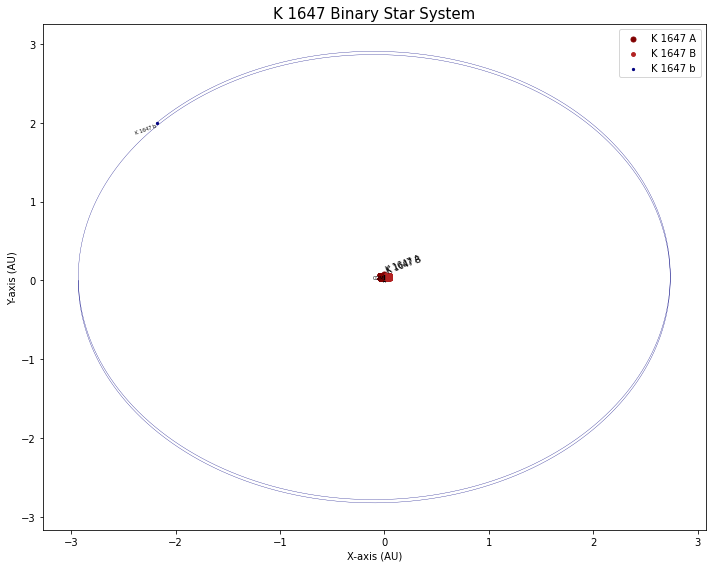

In [109]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

body_indices = 6 * np.arange(0, len(bodies)).astype(int)

for j in body_indices:
    ax.plot(sol[:, j], sol[:, j + 1], color = bodies[int(j / 6)].c, \
            linestyle = '-', linewidth = bodies[int(j / 6)].lw)
    ax.scatter(sol[-1, j], sol[-1, j + 1], color = bodies[int(j / 6)].c, \
            marker = 'o', s = bodies[int(j / 6)].s, label = bodies[int(j / 6)].n)
    ax.text(sol[-1, j], sol[-1, j + 1], bodies[int(j / 6)].n, \
            rotation = 20, color = 'black', ha = bodies[int(j / 6)].ha, va = bodies[int(j / 6)].va, \
            fontsize = bodies[int(j / 6)].t)

ax.plot(com_pos[:, 0], com_pos[:, 1], color = 'black', linestyle = '--')
ax.scatter(com_pos[0, 0], com_pos[0, 1], color = 'black', marker = 'x', s = 10)
ax.text(com_pos[0, 0], com_pos[0, 1], 'COM', \
        color = 'black', ha = 'right', va = 'bottom', fontsize = 5)

ax.set_title('K 1647 Binary Star System', fontsize = 15)
ax.set_xlim(min_x - mid_x * 0.1, max_x + mid_x * 0.1)
ax.set_ylim(min_y - mid_y * 0.1, max_y + mid_y * 0.1)
ax.set_xlabel('X-axis (AU)', fontsize = 10)
ax.set_ylabel('Y-axis (AU)', fontsize = 10) 

plt.tight_layout(w_pad = 5)
plt.legend()
plt.show()

# Multi-Test Orbits

In [ ]:
#Gravitational constant; Units: AU^3 SolMass^-1 yr^-2
G = const.G.to(u.AU**3 / (u.solMass * u.yr**2)).value

#Masses; Units: SolMass
mS1 = 1.16 #Star 1: Kepler 1647
mS2 = 0.968 #Star 2: Kepler 1647B
mP1 = 1.56*u.jupiterMass.to(u.solMass) #Planet 1: Kepler 1647b

#Planet eccentricity and semi-major axis
e1 = 0.0581

a1 = 2.72

aT1 = 0.5
aT2 = 1
aT3 = 1.5
aT4 = 2
aT5 = 3

#Position vectors wrt Star 1; Units: AU
rS1S1 = Vector(0, 0, 0)
rS1S2 = Vector(0.127, 0, 0)
rS1P1 = Vector(-a1 * (1 + e1), 0, 0)

rS1PT1 = Vector(-aT1 * (1 + e1), 0, 0)
rS1PT2 = Vector(-aT2 * (1 + e1), 0, 0)
rS1PT3 = Vector(-aT3 * (1 + e1), 0, 0)
rS1PT4 = Vector(-aT4 * (1 + e1), 0, 0)
rS1PT5 = Vector(-aT5 * (1 + e1), 0, 0)

#COM position wrt Star 1, Units: AU
com_x = (rS1S2.x * mS2 + rS1P1.x * mP1 ) / (mS1 + mS2  )
com_y = (rS1S2.y * mS2 + rS1P1.y * mP1 ) / (mS1 + mS2  )
com_z = (rS1S2.z * mS2 + rS1P1.z * mP1 ) / (mS1 + mS2 )

com_S1 = Vector(com_x, com_y, com_z)

#Position vectors wrt COM; Units: AU
rS1 = rS1S1 - com_S1
rS2 = rS1S2 - com_S1
rP1 = rS1P1 - com_S1

rPT1 = rS1PT1 - com_S1
rPT2 = rS1PT2 - com_S1
rPT3 = rS1PT3 - com_S1
rPT4 = rS1PT4 - com_S1
rPT5 = rS1PT5 - com_S1
com = com_S1 - com_S1

print(com.y)

In [164]:
#Direction to "face-on observer"; Defines normal vector to the plane
obs = Vector(0, 0, 1).norm()

#Calculating phi and theta angles of obs vector in spherical coordinates
#phi represents orbital inclination of system when facing XY-plane. (0 deg = face-on, 90 deg = edge-on)
if (obs.x == 0 and obs.y == 0):
    theta, phi = 0, 0
else:
    theta = np.arctan(obs.y / obs.x)
    phi = np.arctan(np.sqrt(obs.x**2 + obs.y**2) / obs.z)

print(phi, theta)
#e1 = 0.01
eS = 0.16

#Rotating plane of system to be perpendicular to obs vector
pl_norm = (Vector(0, 0, 1).rotate('y', phi)).rotate('z', theta)

rS1 = rS1.rotate('y', phi).rotate('z', theta)
rS2 = rS2.rotate('y', phi).rotate('z', theta)
rP1 = rP1.rotate('y', phi).rotate('z', theta)

rPT1 = rPT1.rotate('y', phi).rotate('z', theta)
rPT2 = rPT2.rotate('y', phi).rotate('z', theta)
rPT3 = rPT3.rotate('y', phi).rotate('z', theta)
rPT4 = rPT4.rotate('y', phi).rotate('z', theta)
rPT5 = rPT5.rotate('y', phi).rotate('z', theta)

#Period; Units: yr
pS = np.sqrt((4 * np.pi**2 * (rS1S2.leng())**3 ) / (G * (mS1 + mS2 + mP1)))
pP1 = np.sqrt((4 * np.pi**2 * (a1)**3) / (G * (mS1 + mS2 )))

pPT1 = np.sqrt((4 * np.pi**2 * (aT1)**3) / (G * (mS1 + mS2 )))
pPT2 = np.sqrt((4 * np.pi**2 * (aT2)**3) / (G * (mS1 + mS2 )))
pPT3 = np.sqrt((4 * np.pi**2 * (aT3)**3) / (G * (mS1 + mS2 )))
pPT4 = np.sqrt((4 * np.pi**2 * (aT4)**3) / (G * (mS1 + mS2 )))
pPT5 = np.sqrt((4 * np.pi**2 * (aT5)**3) / (G * (mS1 + mS2 )))

#Orbital Velocity; Units: AU yr^-1
vS1 = (2 * np.pi * (rS1.leng() - com.leng()) / pS)  * obs.cross(rS1).norm() * np.sqrt((1 - eS) / (1 + eS))
vS2 = (2 * np.pi * (rS2.leng() - com.leng()) / pS)  * obs.cross(rS2).norm() * np.sqrt((1 - eS) / (1 + eS))
vP1 = ((2 * np.pi * a1) / pP1) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rP1).norm()

vPT1 = ((2 * np.pi * aT1) / pPT1) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rPT1).norm()
vPT2 = ((2 * np.pi * aT2) / pPT2) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rPT2).norm()
vPT3 = ((2 * np.pi * aT3) / pPT3) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rPT3).norm()
vPT4 = ((2 * np.pi * aT4) / pPT4) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rPT4).norm()
vPT5 = ((2 * np.pi * aT5) / pPT5) * np.sqrt((1 - e1) / (1 + e1)) * obs.cross(rPT5).norm()

# print('The planets orbit is:', (pP1 * 365), 'days. Which would make it', (1107.59/(pP1 * 365) * 100)
#       , '% accurate to observations.' )
# print('The Suns orbit is:', (pS * 365), 'days. Which would make it', (11.259/(pS * 365) * 100)
#       , '% accurate to observations.' )
# print('Calculated',vS1.y, vS2.y, vP1.y)
vS1.y = -1.77
vS2.y = 2.157


0 0


In [165]:
s1 = Body(rS1, vS1, mS1, 0.16, 'maroon', 25, 1, 'left', 'bottom','K 1647 A', 8)
s2 = Body(rS2, vS2, mS2, 0.16, 'firebrick', 15, 1, 'left', 'bottom', 'K 1647 B', 8)
p1 = Body(rP1, vP1, mP1, e1, '#000080', 5, 0.3, 'right', 'top', 'K 1647 b', 5)

pT1 = Body(rPT1, vPT1, mP1, e1, '#073B3A', 5, 0.3, 'right', 'top', 'a = 0.5', 5)
pT2 = Body(rPT2, vPT2, mP1, e1, '#0B6E4F', 5, 0.3, 'right', 'top', 'a = 1', 5)
pT3 = Body(rPT3, vPT3, mP1, e1, '#0B6233', 5, 0.3, 'right', 'top', 'a = 1.5', 5)
pT4 = Body(rPT4, vPT4, mP1, e1, '#00A86B', 5, 0.3, 'right', 'top', 'a = 2', 5)
pT5 = Body(rPT5, vPT5, mP1, e1, '#043927', 5, 0.3, 'right', 'top', 'a = 3', 5)


stars = np.array([s1, s2])
planets = np.array([p1, pT1, pT2, pT3, pT4, pT5])
bodies = np.concatenate([stars, planets])
#bodies = np.concatenate([stars])
print(b.m)

0.001489167004992147


In [166]:
init_params = np.array([])
masses = np.array([])

for b in bodies:
    init_params = np.append(init_params, [b.pos.x, b.pos.y, b.pos.z, b.vel.x, b.vel.y, b.vel.z])
    masses = np.append(masses, b.m)

time_span = np.linspace(0, 2*pP1, 5000)

#Body Positions
sol = scipy.integrate.odeint(GravityEquation, init_params, time_span, args = (masses,))

#COM Positions
com_num = np.zeros((len(sol), 3))
for i in range(len(masses)):
    com_num += masses[i] * sol[:, (6 * i): (6 * i) + 3]

com_pos = com_num / np.sum(masses)

#Size of Plots
max_x = np.max(sol[:, ::6]) + 0.05
min_x = np.min(sol[:, ::6]) - 0.05
mid_x = (abs(max_x) + abs(min_x)) / 2
max_y = np.max(sol[:, 1::6]) + 0.05
min_y = np.min(sol[:, 1::6]) - 0.05
mid_y = (abs(max_y) + abs(min_y)) / 2
max_z = np.max(sol[:, 2::6]) + 0.05
min_z = np.min(sol[:, 2::6]) - 0.05
mid_z = (abs(max_z) + abs(min_z)) / 2
print(com_pos)

[[-6.13200053e-03  0.00000000e+00  0.00000000e+00]
 [-6.13200053e-03 -1.79503171e-05  0.00000000e+00]
 [-6.13200053e-03 -3.59006342e-05  0.00000000e+00]
 ...
 [-6.13200053e-03 -8.96977344e-02  0.00000000e+00]
 [-6.13200053e-03 -8.97156847e-02  0.00000000e+00]
 [-6.13200053e-03 -8.97336351e-02  0.00000000e+00]]


In [15]:
masses = np.array([1.16,0.968,0.00148917])
sol

array([[-5.57566399e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -5.46923412e+00,  0.00000000e+00],
       [-5.39653436e-02, -1.16985239e-02,  0.00000000e+00, ...,
         1.32017366e-02, -5.46921726e+00,  0.00000000e+00],
       [-4.86134581e-02, -2.26187070e-02,  0.00000000e+00, ...,
         2.63997202e-02, -5.46916611e+00,  0.00000000e+00],
       ...,
       [ 3.56425717e-03,  1.89204836e+00,  0.00000000e+00, ...,
        -1.80395473e+00,  4.02105997e+00,  0.00000000e+00],
       [ 1.77960498e-02,  1.90584867e+00,  0.00000000e+00, ...,
        -1.80919384e+00,  4.01824036e+00,  0.00000000e+00],
       [ 2.48784605e-02,  1.92594631e+00,  0.00000000e+00, ...,
        -1.81442953e+00,  4.01541384e+00,  0.00000000e+00]])

In [152]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

body_indices = 6 * np.arange(0, len(bodies)).astype(int)

for j in body_indices:
    ax.plot(sol[:, j], sol[:, j + 1], color = bodies[int(j / 6)].c, \
            linestyle = '-', linewidth = bodies[int(j / 6)].lw)
    ax.scatter(sol[-1, j], sol[-1, j + 1], color = bodies[int(j / 6)].c, \
            marker = 'o', s = bodies[int(j / 6)].s, label = bodies[int(j / 6)].n)
    ax.text(sol[-1, j], sol[-1, j + 1], bodies[int(j / 6)].n, \
            rotation = 20, color = 'black', ha = bodies[int(j / 6)].ha, va = bodies[int(j / 6)].va, \
            fontsize = bodies[int(j / 6)].t)

ax.plot(com_pos[:, 0], com_pos[:, 1], color = 'black', linestyle = '--')
ax.scatter(com_pos[0, 0], com_pos[0, 1], color = 'black', marker = 'x', s = 10)
ax.text(com_pos[0, 0], com_pos[0, 1], 'COM', \
        color = 'black', ha = 'right', va = 'bottom', fontsize = 5)

ax.set_title('K 1647 Binary Star System', fontsize = 15)
ax.set_xlim(min_x - mid_x * 0.1, max_x + mid_x * 0.1)
ax.set_ylim(min_y - mid_y * 0.1, max_y + mid_y * 0.1)
ax.set_xlabel('X-axis (AU)', fontsize = 10)
ax.set_ylabel('Y-axis (AU)', fontsize = 10) 

plt.tight_layout(w_pad = 5)
plt.legend()
plt.show()

# MP4 Save

In [168]:
%matplotlib qt
metadata = dict(title='Binary Kepler 1647 system', artist='Matplotlib',comment='Based on made data .')
writer = FFMpegWriter(fps=15, metadata=metadata)
fig = plt.figure()

In [170]:

from matplotlib.animation import FuncAnimation


fig, ax = plt.subplots(figsize=(10, 8))
body_indices = 6 * np.arange(0, len(bodies)).astype(int)
frame = sol.shape[0]
def update(frame):
    ax.clear()

    for j in body_indices:
        ax.plot(sol[:frame, j], sol[:frame, j + 1], color=bodies[int(j / 6)].c, \
                linestyle='-', linewidth=bodies[int(j / 6)].lw)
        ax.scatter(sol[frame, j], sol[frame, j + 1], color=bodies[int(j / 6)].c, \
                marker='o', s=bodies[int(j / 6)].s, label=bodies[int(j / 6)].n)
        ax.text(sol[frame, j], sol[frame, j + 1], bodies[int(j / 6)].n, \
                rotation=20, color='black', ha=bodies[int(j / 6)].ha, va=bodies[int(j / 6)].va, \
                fontsize=bodies[int(j / 6)].t)

    ax.plot(com_pos[:frame, 0], com_pos[:frame, 1], color='black', linestyle='--')
    ax.scatter(com_pos[frame, 0], com_pos[frame, 1], color='black', marker='x', s=10)
    ax.text(com_pos[frame, 0], com_pos[frame, 1], 'COM', \
            color='black', ha='right', va='bottom', fontsize=5)

    ax.set_title('K 1647 Binary Star System', fontsize=15)
    ax.set_xlim(min_x - mid_x * 0.1, max_x + mid_x * 0.1)
    ax.set_ylim(min_y - mid_y * 0.1, max_y + mid_y * 0.1)
    ax.set_xlabel('X-axis (AU)', fontsize=10)
    ax.set_ylabel('Y-axis (AU)', fontsize=10) 

    plt.legend()



# Create the animation
animation = FuncAnimation(fig, update, frames=frame, interval=50)

# Save the animation as a video file

with writer.saving(fig, "animation.mp4", dpi=200):
    for frame in range(frame):
        update(frame)
        writer.grab_frame()
        if (frame % 10 == 0): 
            print('.', end='')

plt.show()


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [156]:
sol.shape[0]

5000